**Environment Setup & Hugging Face Login**

In [1]:
!pip install --upgrade transformers huggingface_hub -q
!pip install transformers[torch] datasets scikit-learn sentencepiece sacremoses accelerate packaging -q

import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, TrainingArguments, Trainer, pipeline, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
import sklearn
from packaging import version
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

RNG = 42

# --- MOUNTING GOOGLE DRIVE ---
drive.mount('/content/drive')

# --- LOGGING INTO HUGGING FACE ---
notebook_login()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.0 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/Thesis 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# --- DATA CLEANING AND MULTICLASS LABEL CREATION (from originalScore) ---
df = df.dropna(subset=['reviewText', 'originalScore']).copy()

# 5 bins like your script
bins = [0, 2, 4, 6, 8, 10]
labels = [0, 1, 2, 3, 4]
class_names = ['Very Negative', 'Negative', 'Average', 'Positive', 'Very Positive']
df['label'] = pd.cut(df['originalScore'], bins=bins, labels=labels, right=True, include_lowest=True).astype(int)

print("--- Class Distribution (Full) ---")
print(df['label'].value_counts().sort_index())

# --- STRATIFIED SPLIT (text + label only for split; augmentation only after split) ---
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

print("\n--- Train/Test Class Distribution (pre-augmentation) ---")
print("Train:\n", train_df['label'].value_counts().sort_index())
print("\nTest:\n",  test_df['label'].value_counts().sort_index())


--- Class Distribution (Full) ---
label
0    11436
1    40617
2    57315
3    64737
4    20696
Name: count, dtype: int64

--- Train/Test Class Distribution (pre-augmentation) ---
Train:
 label
0     9149
1    32493
2    45852
3    51789
4    16557
Name: count, dtype: int64

Test:
 label
0     2287
1     8124
2    11463
3    12948
4     4139
Name: count, dtype: int64


**Data Resampling (Upsampling & Downsampling)**

In [4]:
# ---------- Back-translation pipelines ----------
device = 0 if torch.cuda.is_available() else -1
print("\nInitializing back-translation models...")
en_to_de = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de", device=device)
de_to_en = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en", device=device)

def back_translate(texts, batch_size=32):
    de = en_to_de(texts, batch_size=batch_size, truncation=True)
    de_texts = [x['translation_text'] for x in de]
    en = de_to_en(de_texts, batch_size=batch_size, truncation=True)
    return [x['translation_text'] for x in en]

# ---------- Class balancing params (TRAIN ONLY) ----------
# Match your earlier intent but ONLY on train:
AUGMENT_CLASS = 0        # upsample this class via back-translation
AUGMENT_TO    = 15000    # target count for class 0 in TRAIN
DOWNSAMPLE_TO = {2: 40000, 3: 45000}  # downsample only if above this count (TRAIN)

# --- Start with train_df and apply downsampling first ---
train_balanced = train_df.copy()

for cls_id, tgt in DOWNSAMPLE_TO.items():
    cur = (train_balanced['label'] == cls_id).sum()
    if cur > tgt:
        keep = train_balanced[train_balanced['label'] == cls_id].sample(n=tgt, random_state=RNG)
        rest = train_balanced[train_balanced['label'] != cls_id]
        train_balanced = pd.concat([rest, keep], ignore_index=True)

# --- Then upsample class 0 via back-translation to AUGMENT_TO ---
cur0 = (train_balanced['label'] == AUGMENT_CLASS).sum()
if cur0 < AUGMENT_TO:
    need = AUGMENT_TO - cur0
    base = train_balanced[train_balanced['label'] == AUGMENT_CLASS]
    # sample rows (with replacement) to augment
    to_aug = base.sample(n=need, replace=True, random_state=RNG).copy()

    # back-translate only the reviewText
    texts = to_aug['reviewText'].tolist()
    print(f"\nAugmenting class {AUGMENT_CLASS}: generating {need} samples via back-translation...")
    aug_texts = back_translate(texts, batch_size=32)
    to_aug['reviewText'] = aug_texts

    # combine back into train
    train_balanced = pd.concat([train_balanced, to_aug], ignore_index=True)

# --- Final train distribution after balancing ---
print("\n--- Train Class Distribution (post-augmentation/balancing) ---")
print(train_balanced['label'].value_counts().sort_index())



Initializing back-translation models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0



Augmenting class 0: generating 5851 samples via back-translation...

--- Train Class Distribution (post-augmentation/balancing) ---
label
0    15000
1    32493
2    40000
3    45000
4    16557
Name: count, dtype: int64


**Dataset Preparation and Tokenization**

In [5]:

# --- Prepare text fields ---
for frame in [train_balanced, test_df]:
    frame['title'] = frame['title'].fillna("")
    frame['genre'] = frame['genre'].fillna("Unknown")

train_balanced['combined_text'] = train_balanced['title'] + " [SEP] " + train_balanced['reviewText']
test_df['combined_text'] = test_df['title'] + " [SEP] " + test_df['reviewText']

# --- NUMERIC (fit on TRAIN only) ---
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_medians = train_balanced[NUMERIC_COLS].median(numeric_only=True)
scaler = StandardScaler().fit(train_balanced[NUMERIC_COLS].fillna(train_medians).values)

# --- GENRE (multi-label binarizer fit on TRAIN only) ---
mlb = MultiLabelBinarizer()
mlb.fit(train_balanced['genre'].fillna("Unknown").str.split(', '))

# --- LANGUAGE (OHE fit on TRAIN only, version-safe param) ---
train_lang = train_balanced['language_encoded'].astype('Int64').astype(str).fillna('unknown')
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)
ohe_lang.fit(train_lang.to_frame())

# --- DIRECTOR: frequency (log1p) + 5-fold leak-safe target mean (fit on TRAIN only) ---
def director_features(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits=5, seed=RNG):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # frequency from TRAIN only
    freq = s_train.value_counts()
    tr_f = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_f = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # K-fold target mean (leak-safe)
    y = y.astype(np.float32)
    global_mean = y.mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    tr_te = np.zeros(len(s_train), dtype=np.float32)

    for tr_i, val_i in skf.split(np.zeros(len(y)), train_balanced['label'].values):
        tr_part, y_part = s_train.iloc[tr_i], y[tr_i]
        means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index == idx.name].mean())
        tr_te[val_i] = s_train.iloc[val_i].map(means).fillna(global_mean).astype(np.float32).values

    # test uses full-train means
    full_means = s_train.groupby(s_train).apply(lambda idx: y[s_train.index == idx.name].mean())
    te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]
    return tr_f, te_f, tr_te[:, None], te_te

y_train_bal = train_balanced['label'].values
if 'director' in train_balanced.columns:
    dtr_f, dte_f, dtr_te, dte_te = director_features(train_balanced['director'], y_train_bal, test_df['director'])
else:
    dtr_f, dte_f, dtr_te, dte_te = director_features(
        train_balanced['director_encoded'].astype(str), y_train_bal,
        test_df['director_encoded'].astype(str)
    )
dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)  # (N, 2)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)  # (M, 2)

# --- Helper to build tensors for any split using TRAIN-fitted transformers ---
def build_features(split_df: pd.DataFrame, dir_block: np.ndarray):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # numeric
    num_scaled = scaler.transform(split_df[NUMERIC_COLS].fillna(train_medians).values).astype(np.float32)
    out['numerical_features'] = [row for row in num_scaled]

    # genre multi-hot
    genre_bin = mlb.transform(split_df['genre'].fillna("Unknown").str.split(', ')).astype(np.float32)

    # language one-hot
    lang = split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
    lang_ohe = ohe_lang.transform(lang.to_frame()).astype(np.float32)

    # cat = genre | language | director(2)
    cat = np.concatenate([genre_bin, lang_ohe, dir_block], axis=1).astype(np.float32)
    out['categorical_features'] = [row for row in cat]
    return out

train_feats = build_features(train_balanced, dir_train_block)
test_feats  = build_features(test_df,      dir_test_block)

num_numerical_features = 3
num_genre = len(mlb.classes_)
num_lang  = ohe_lang.get_feature_names_out().shape[0]
num_dir_enc = 2
num_categorical_features = num_genre + num_lang + num_dir_enc

print("\nFeature dims → numeric:", num_numerical_features,
      "| genre:", num_genre, "| lang:", num_lang,
      "| director_block:", num_dir_enc, "| categorical total:", num_categorical_features)


/tmp/ipython-input-1730081445.py:44: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index == idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-1730081445.py:44: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index == idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-1730081445.py:44: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index == idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-


Feature dims → numeric: 3 | genre: 31 | lang: 14 | director_block: 2 | categorical total: 47


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


In [6]:
final_train_df = pd.DataFrame({
    'combined_text': train_feats['combined_text'],
    'label': train_feats['label'],
    'numerical_features': train_feats['numerical_features'],
    'categorical_features': train_feats['categorical_features'],
})
final_test_df = pd.DataFrame({
    'combined_text': test_feats['combined_text'],
    'label': test_feats['label'],
    'numerical_features': test_feats['numerical_features'],
    'categorical_features': test_feats['categorical_features'],
})

raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(final_train_df),
    'test':  Dataset.from_pandas(final_test_df),
})

MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_multimodal_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)
cols_to_remove = [c for c in ["combined_text", "__index_level_0__"] if c in tokenized_multimodal_datasets["train"].column_names]
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(cols_to_remove)
tokenized_multimodal_datasets.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/149050 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

**Custom Model**

In [7]:
# --- MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]
        pooled_output = self.dropout(cls_token_output)
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        numerical_features = np.stack([np.array(f['numerical_features'], dtype=np.float32) for f in features])
        categorical_features = np.stack([np.array(f['categorical_features'], dtype=np.float32) for f in features])
        batch['labels'] = torch.tensor([int(f['label']) for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.tensor(numerical_features, dtype=torch.float32)
        batch['categorical_features'] = torch.tensor(categorical_features, dtype=torch.float32)
        return batch

# --- INIT MODEL & COLLATOR ---
num_labels_model = len(class_names)  # 5
multimodal_model = MultimodalClassifier(
    num_labels=num_labels_model,
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features
)
data_collator = MultimodalDataCollator(tokenizer)

# --- METRICS (multiclass) ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1_weighted': f1_w, 'precision_weighted': precision_w, 'recall_weighted': recall_w}

# --- TRAINING ARGS ---
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_multiclass_multimodal_ALL_FEATURES_DIRTE",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50
)

# --- TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n--- Starting Training for Multiclass Multimodal Model (ALL FEATURES + Dir TargetEnc) ---")
multimodal_trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


--- Starting Training for Multiclass Multimodal Model (ALL FEATURES + Dir TargetEnc) ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rafid2542 (rafid2542-ahsanullah-university-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,1.091500,1.069210,0.520469,0.508634,0.523453,0.520469
2,0.944100,1.071510,0.525243,0.514385,0.524960,0.525243
3,0.827000,1.153158,0.518365,0.515451,0.514629,0.518365


TrainOutput(global_step=27948, training_loss=0.9759604115675188, metrics={'train_runtime': 9786.3803, 'train_samples_per_second': 45.691, 'train_steps_per_second': 2.856, 'total_flos': 0.0, 'train_loss': 0.9759604115675188, 'epoch': 3.0})

**Final Evaluation and Saving**

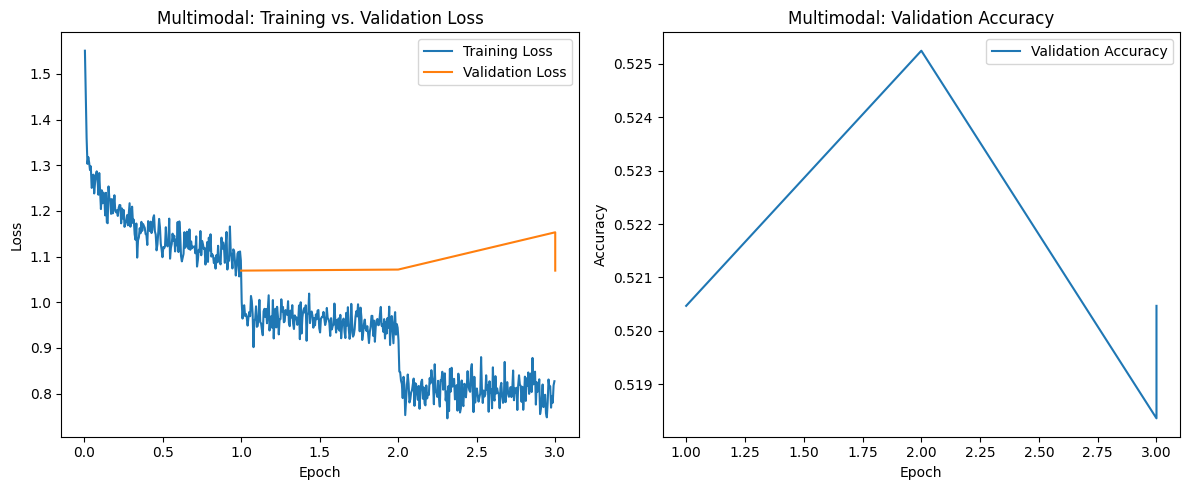


--- Final Evaluation on Test Set (Multimodal, ALL FEATURES + Director TargetEnc) ---


{'eval_loss': 1.0692102909088135, 'eval_accuracy': 0.5204691871358538, 'eval_f1_weighted': 0.5086335912281499, 'eval_precision_weighted': 0.5234531711400792, 'eval_recall_weighted': 0.5204691871358538, 'eval_runtime': 256.4268, 'eval_samples_per_second': 151.938, 'eval_steps_per_second': 9.5, 'epoch': 3.0}
Logits shape: (38961, 5)

--- Classification Report (Multimodal, ALL FEATURES + Director TargetEnc) ---
               precision    recall  f1-score   support

Very Negative       0.42      0.33      0.37      2287
     Negative       0.46      0.49      0.48      8124
      Average       0.47      0.47      0.47     11463
     Positive       0.59      0.71      0.64     12948
Very Positive       0.64      0.22      0.33      4139

     accuracy                           0.52     38961
    macro avg       0.52      0.44      0.46     38961
 weighted avg       0.52      0.52      0.51     38961



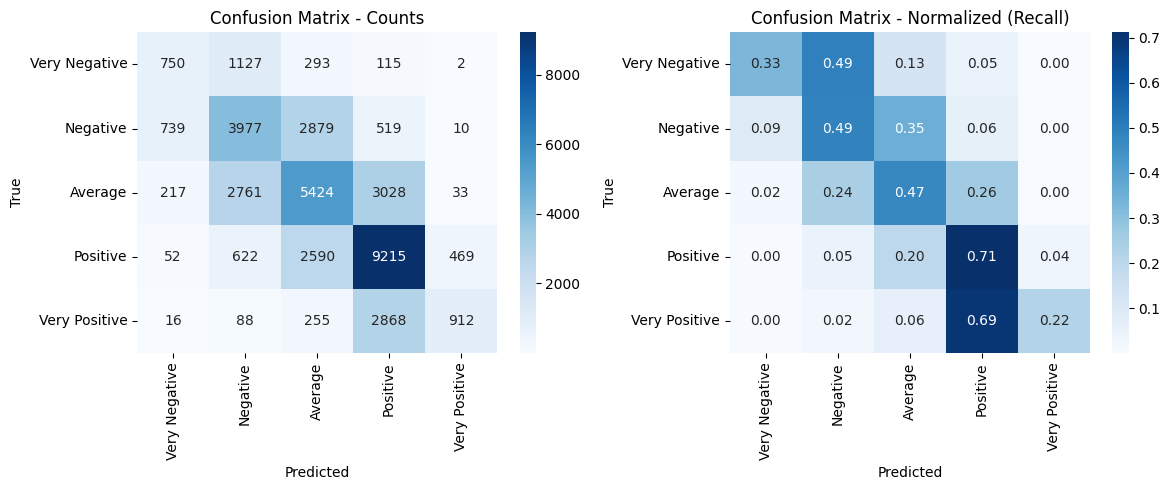

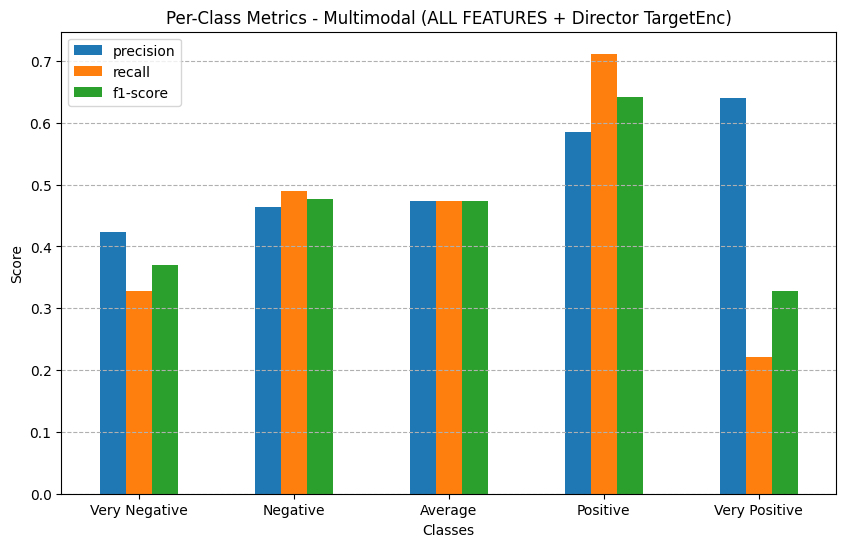


Multimodal model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/[Multiclass]fine-tuned_multimodal_ALL_FEATURES_DIRTE
First 10 preds vs true: [(np.int64(2), np.int64(1)), (np.int64(3), np.int64(3)), (np.int64(2), np.int64(1)), (np.int64(2), np.int64(0)), (np.int64(3), np.int64(3)), (np.int64(0), np.int64(0)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(4)), (np.int64(3), np.int64(3)), (np.int64(3), np.int64(2))]


In [9]:
# ==========================
# EVALUATE • REPORT • PLOTS • SAVE (Multimodal)
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

try:
    class_names
except NameError:
    num_labels = getattr(multimodal_trainer.model.config, "num_labels", None)
    if num_labels is None:
        uniq = sorted(set(tokenized_multimodal_datasets["test"]["label"]))
        num_labels = len(uniq)
    class_names = [f"Class {i}" for i in range(num_labels)]
    print(f"[Info] 'class_names' not found; using defaults: {class_names}")

# --- Curves ---
log_history = multimodal_trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
         [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
         [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Multimodal: Training vs. Validation Loss'); plt.legend()

plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
             [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Multimodal: Validation Accuracy'); plt.legend()
else:
    plt.text(0.5, 0.5, 'No eval accuracy logged', ha='center', va='center')
    plt.axis('off')
plt.tight_layout(); plt.show()

# --- Final Eval ---
print("\n--- Final Evaluation on Test Set (Multimodal, ALL FEATURES + Director TargetEnc) ---")
multimodal_eval_results = multimodal_trainer.evaluate()
print(multimodal_eval_results)

pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])
logits = pred_out.predictions[0] if isinstance(pred_out.predictions, (list, tuple)) else pred_out.predictions
logits = np.asarray(logits)
print("Logits shape:", logits.shape)

# logits -> labels
if logits.ndim == 2:
    multimodal_predicted_labels = np.argmax(logits, axis=-1)
    num_classes = logits.shape[1]
elif logits.ndim == 1:
    # single-logit case (binary); keep for robustness
    multimodal_predicted_labels = (logits > 0).astype(int)
    num_classes = 2
else:
    raise ValueError(f"Unexpected logits ndim: {logits.ndim}")

if len(class_names) != num_classes:
    print(f"[Warn] Adjusting class_names from {len(class_names)} to {num_classes}.")
    class_names = [f"Class {i}" for i in range(num_classes)]

true_labels = np.asarray(tokenized_multimodal_datasets["test"]["label"]).astype(int)

# --- Report ---
print("\n--- Classification Report (Multimodal, ALL FEATURES + Director TargetEnc) ---")
report_text = classification_report(true_labels, multimodal_predicted_labels,
                                    target_names=class_names, zero_division=0)
print(report_text)

report = classification_report(true_labels, multimodal_predicted_labels,
                               target_names=class_names, output_dict=True, zero_division=0)

# --- Confusion Matrices ---
cm = confusion_matrix(true_labels, multimodal_predicted_labels, labels=list(range(num_classes)))
row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Counts')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Normalized (Recall)')
plt.tight_layout(); plt.show()

# --- Per-class bar chart ---
report_df = pd.DataFrame(report).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics - Multimodal (ALL FEATURES + Director TargetEnc)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend()
plt.show()

# --- SAVE MODEL ---
output_multimodal_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Multiclass]fine-tuned_multimodal_ALL_FEATURES_DIRTE"
multimodal_trainer.save_model(output_multimodal_model_path)
print(f"\nMultimodal model saved to: {output_multimodal_model_path}")

# --- QUICK PEEK ---
print("First 10 preds vs true:",
      list(zip(multimodal_predicted_labels[:10], true_labels[:10])))
